In [3]:
import pandas as pd
import numpy as np
from lapjv import lapjv #https://github.com/src-d/lapjv
  
from scipy.spatial.distance import cdist
import math
from matplotlib import pyplot as plt
import seaborn as sns


In [4]:
#Load in both the 2d projection - t-sne or umap and the cluster information
df = pd.read_csv('./data/projection.csv')
df2 = pd.read_csv('./data/clusters.csv')
df = df.merge(df2, on='Barcode')

#Change as appropriate for the projection headers
tsne = df[['TSNE-1', 'TSNE-2']].values


In [5]:
#Perform linear assignment to convert t-sne representation to grid
#Adapted from: https://github.com/kylemcdonald/CloudToGrid/blob/master/CloudToGrid.ipynb

data2d = tsne.copy()
data2d -= data2d.min(axis=0)
data2d /= data2d.max(axis=0)
side = math.ceil(math.sqrt(data2d.shape[0]))
totalDataPoints = side * side
data2d.resize(totalDataPoints, 2)
xv, yv = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side))
grid = np.dstack((xv, yv)).reshape(-1, 2)
cost = cdist(grid, data2d , 'sqeuclidean')
cost = cost * (1000000000. / cost.max() )
row_assigns, col_assigns, _ = lapjv(cost)
tsneMap = grid[col_assigns]

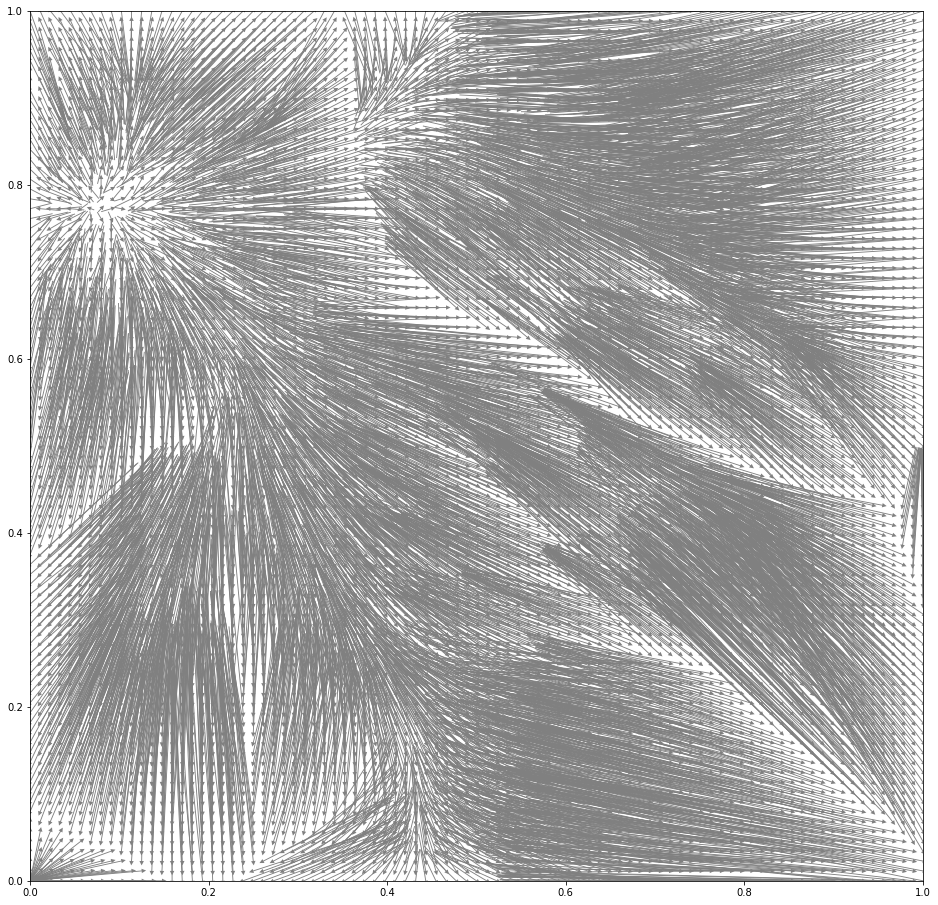

In [10]:
#Generate a figure showing how the points move from the projection to the grid
grid_hu = tsneMap
plt.figure(figsize=(16, 16))

for start, end in zip(data2d, grid_hu):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.005, head_width=0.005, linewidth=0.001,color="grey")
plt.show()

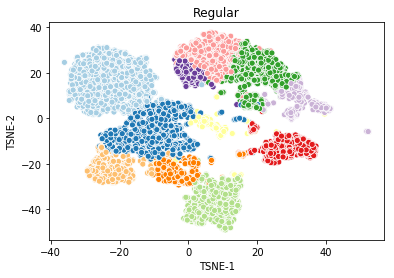

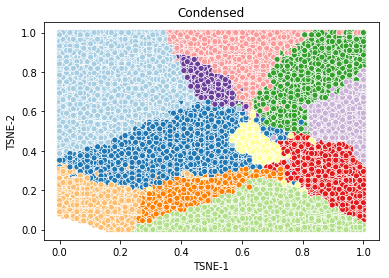

In [252]:
#Graph two versions side by side
tdf = pd.DataFrame(tsneMap, columns=['TSNE-1', 'TSNE-2'])
tdf['Barcode'] = df['Barcode']
tdf['Cluster'] = df['Cluster']
plt.title("Regular")
palette = sns.mpl_palette("Paired",len(set(df['Cluster'])))
sns.scatterplot(x="TSNE-1", y="TSNE-2", hue='Cluster', data=df, palette = palette,legend=None)
plt.show()
plt.title("Condensed" )
sns.scatterplot(x="TSNE-1", y="TSNE-2", hue='Cluster', data=tdf, palette = palette,legend=None)
plt.show()


In [214]:
#Experiment with edge detection
#https://stackoverflow.com/questions/29434533/edge-detection-for-image-stored-in-matrix
def reformat_2d_array(df, side, value):
    inData_matrix = np.zeros((side, side,3))
    for index, row  in df.iterrows():
        x = int((row['TSNE-1']-0.000001) * side)
        y = int((row['TSNE-2']-0.000001) * side)
        if math.isnan(row[value]):
            inData_matrix[x][y] = (0,0,0)
        else:
            inData_matrix[x][y] = sns.color_palette("Paired")[int(row[value])]
        
    return inData_matrix

In [217]:
mat = reformat_2d_array(tdf, side, "Cluster")

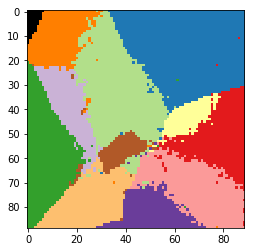

In [218]:
plt.imshow(mat, interpolation='nearest')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


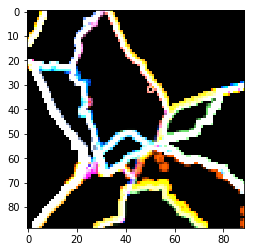

In [247]:
from scipy import ndimage
import scipy as sp
import skimage
from PIL import Image
import PIL
from scipy.ndimage import median_filter

im = mat
im = median_filter(im, size=3)
plt.imshow(im)
sx = ndimage.sobel(im, axis=0, mode='nearest')
sy = ndimage.sobel(im, axis=1, mode='nearest')
sob = np.hypot(sx, sy)

plt.imshow(sob, vmax=0.00001)